Després de veure els resultats dels models sense features, ara toca experimentar amb quins features i quina codificació fan que el model millori.

In [13]:
import nltk
import re
import unicodedata
from nltk.tag import CRFTagger
nltk.download('conll2002')
from nltk.corpus import conll2002
from sklearn.metrics import f1_score, classification_report

tr_sp = conll2002.iob_sents('esp.train') # Train Español
dev_sp = conll2002.iob_sents('esp.testa') # Dev Español
test_sp = conll2002.iob_sents('esp.testb') # Test Español

tr_ne = conll2002.iob_sents('ned.train') # Train Neerlandés
dev_ne = conll2002.iob_sents('ned.testa') # Dev Neerlandés
test_ne = conll2002.iob_sents('ned.testb') # Test Neerlandés

[nltk_data] Downloading package conll2002 to
[nltk_data]     C:\Users\baske\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!


In [14]:
# Transformar: dejar solo (palabra, NER)
train_sents = [[(word, ner) for word, pos, ner in sent] for sent in tr_sp]
test_sents = [[(word, ner) for word, pos, ner in sent] for sent in test_sp]

In [10]:
train_sents[0]

[('Melbourne', 'B-LOC'),
 ('(', 'O'),
 ('Australia', 'B-LOC'),
 (')', 'O'),
 (',', 'O'),
 ('25', 'O'),
 ('may', 'O'),
 ('(', 'O'),
 ('EFE', 'B-ORG'),
 (')', 'O'),
 ('.', 'O')]

In [15]:
def features(tokens, idx):
        """
        Extract features about this word including
            - Current word
            - is it capitalized?
            - Does it have punctuation?
            - Does it have a number?
            - Suffixes up to length 3

        Note that : we might include feature over previous word, next word etc.

        :return: a list which contains the features
        :rtype: list(str)
        """
        pattern = re.compile(r"\d")

        token = tokens[idx]

        feature_list = []

        if not token:
            return feature_list

        # Capitalization
        if token[0].isupper():
            feature_list.append("CAPITALIZATION")

        # Number
        if re.search(pattern, token) is not None:
            feature_list.append("HAS_NUM")

        # Punctuation
        punc_cat = {"Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"}
        if all(unicodedata.category(x) in punc_cat for x in token):
            feature_list.append("PUNCTUATION")

        # Suffix up to length 3
        if len(token) > 1:
            feature_list.append("SUF_" + token[-1:])
        if len(token) > 2:
            feature_list.append("SUF_" + token[-2:])
        if len(token) > 3:
            feature_list.append("SUF_" + token[-3:])
        if len(token) > 4:
            feature_list.append("SUF_" + token[-4:])
                

        # Prefixes
        if len(token) > 1:
            feature_list.append("PREF_" + token[:1])
        if len(token) > 2:
            feature_list.append("PREF_" + token[:2])
        if len(token) > 3:
            feature_list.append("PREF_" + token[:3])
        if len(token) > 4:
            feature_list.append("PREF_" + token[:4])

        if idx > 0:
            prev_token = tokens[idx - 1]
            feature_list.append("PREV_WORD_" + prev_token)
        else:
            feature_list.append("BOS")  # Beginning of sentence

        #Codi per implementar dos tokens anteriors y dos posteriors (té pitjor rendiment que un token)
        """ if idx > 1:
            prev_token = tokens[idx - 1]
            ant_prev_token = tokens[idx - 2]
            feature_list.append("PREV_WORD_" + prev_token + "_" + ant_prev_token)
        elif idx > 0:
            prev_token = tokens[idx - 1]
            feature_list.append("PREV_WORD_" + prev_token)
        else:
            feature_list.append("BOS")  # Beginning of sentence
        
        
        
        if idx < len(tokens) - 2:
            next_token = tokens[idx + 1]
            post_next_token = tokens[idx + 2]
            feature_list.append("NEXT_WORD_" + next_token +"_"+post_next_token)
        elif idx < len(tokens) - 1:
            next_token = tokens[idx + 1]
            feature_list.append("NEXT_WORD_" + next_token)
        else:
            feature_list.append("EOS")  # End of sentence
        """

        # Next word
        if idx < len(tokens) - 1:
            next_token = tokens[idx + 1]
            feature_list.append("NEXT_WORD_" + next_token)
        else:
            feature_list.append("EOS")  # End of sentence

        feature_list.append("WORD_" + token)

        return feature_list


"""
Codi base extret https://www.nltk.org/_modules/nltk/tag/crf.html <- Ampliem els features que venen de base a nltk.tag.CRFTagger()

Features afegits: 
    · Prefixos de fins a longitud 3
    · Tokens anteriors i posteriors
    · ...
"""

'\nCodi base extret https://www.nltk.org/_modules/nltk/tag/crf.html <- Ampliem els features que venen de base a nltk.tag.CRFTagger()\n\nFeatures afegits: \n    · Prefixos de fins a longitud 3\n    · Tokens anteriors i posteriors\n    · ...\n'

In [16]:
ct = nltk.tag.CRFTagger(feature_func=features)
ct.train(train_sents, 'esp_model.crf.tagger')
ct.set_model_file('esp_model.crf.tagger')

In [17]:
predicted_sents = ct.tag_sents([ [word for word, tag in sent] for sent in test_sents ])

In [18]:
#F1-Score a nivell de entitats, nms ens interesa saber si troba be les entitats, no totes les paraules
true_entities = []
predicted_entities = []

for true_sent, pred_sent in zip(test_sents, predicted_sents):
    for (word_t, tag_t), (word_p, tag_p) in zip(true_sent, pred_sent):
        if tag_t != 'O':  # <- Aquí filtrem les paraules que són entitats en el conjunt de test
            true_entities.append(tag_t)
            predicted_entities.append(tag_p)
        elif tag_p != 'O' and tag_t == 'O': # <- Tmb agafem les entitats que el model prediu com entitats pero no ho són.
            true_entities.append(tag_t)
            predicted_entities.append(tag_p)

# Calcular el F1 score (weighted)
f1 = f1_score(true_entities, predicted_entities, average='weighted', zero_division=0)
print(f"F1 Score (weighted) sobre entidades: {f1:.2%}")

# També fem un report del reconeixament
print("\nReporte por clase:")
print(classification_report(true_entities, predicted_entities, zero_division=0))


F1 Score (weighted) sobre entidades: 76.41%

Reporte por clase:
              precision    recall  f1-score   support

       B-LOC       0.82      0.77      0.79      1084
      B-MISC       0.71      0.50      0.59       339
       B-ORG       0.81      0.85      0.83      1400
       B-PER       0.85      0.87      0.86       735
       I-LOC       0.71      0.61      0.65       325
      I-MISC       0.62      0.57      0.59       557
       I-ORG       0.82      0.81      0.81      1104
       I-PER       0.90      0.94      0.92       634
           O       0.00      0.00      0.00       203

    accuracy                           0.76      6381
   macro avg       0.69      0.66      0.67      6381
weighted avg       0.77      0.76      0.76      6381



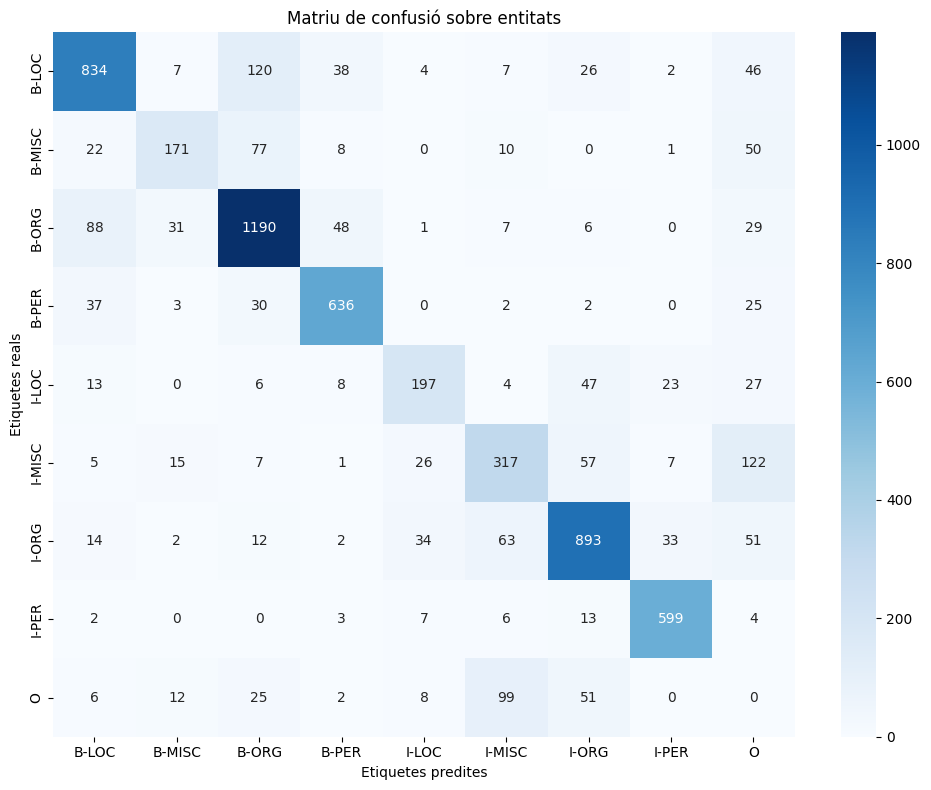

In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = sorted(set(true_entities + predicted_entities))

cm = confusion_matrix(true_entities, predicted_entities, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Etiquetes predites')
plt.ylabel('Etiquetes reals')
plt.title('Matriu de confusió sobre entitats')
plt.tight_layout()
plt.show()


In [20]:
import pandas as pd
from sklearn.metrics import confusion_matrix

labels = sorted(set(true_entities + predicted_entities))

cm = confusion_matrix(true_entities, predicted_entities, labels=labels)

resultats = []
for i, label in enumerate(labels):
    correctes = cm[i, i]
    prediccions_totals = sum(cm[:, i])  # total de vegades que es va predir aquesta etiqueta
    errors = prediccions_totals - correctes
    percentatge = (correctes / prediccions_totals * 100) if prediccions_totals > 0 else 0.0
    resultats.append({
        'Etiqueta': label,
        'Correctes': correctes,
        'Errors': errors,
        '% d\'encerts': f"{percentatge:.2f}%"
    })

df_resultats = pd.DataFrame(resultats)
print(df_resultats)

  Etiqueta  Correctes  Errors % d'encerts
0    B-LOC        834     187      81.68%
1   B-MISC        171      70      70.95%
2    B-ORG       1190     277      81.12%
3    B-PER        636     110      85.25%
4    I-LOC        197      80      71.12%
5   I-MISC        317     198      61.55%
6    I-ORG        893     202      81.55%
7    I-PER        599      66      90.08%
8        O          0     354       0.00%
